# Giới thiệu
* Bài toán: dự đoán loại của một bài báo:
* Tập dữ liệu: [BBC News](http://mlg.ucd.ie/datasets/bbc.html)
* Phân tích dữ liệu, gồm các bước:
  * **Thu thập** dữ liệu
  * **Làm sạch**: tuỳ vào dữ liệu,
    * Text: sai font, sai cú pháp, thuật ngữ viết tắt, v.v. => loại bỏ, chỉnh sửa, ...
    * Hình ảnh: mờ, phân giải chưa đủ, thiếu ánh sáng, mất focus, etc => bỏ, biến đổi: tăng cường chất lượng ảnh, v.v
    
  * **Biến đổi**: trích đặc trưng, chuẩn hoá
  * **Bổ khuyết**: xử lý "Null/None"
  * **Thống kê**:
    * Thống kê về lượng dữ liệu/nhãn
    * Text: size of vocabulary (kích thước từ điển), phân bố từ, etc
    * Ảnh: các biểu đồ phân phối về kích, số nhãn, kích nhãn (phát hiện)
  * Phân phối của đặc trưng:
    * Ví dụ, Dataframe có nhiều cột (đặc trưng);
      * các cột có kiểu dữ liệu và phân bố gì? => chọn đúng kỹ thuật
        * Ví dụ: Chọn kiểu NaiveBayes phù hợp
  * **Rút trích đặc trưng (feature extraction)**
    * Đầu ra: ma trận $NxD$:
      * N: Số mẫu (quan sát, điểm dữ liệu)
      * D: Số đặc trưng (biến/biến độc lập)
  * Phân tích/dự báo bằng học máy
    * Chọn kỹ thuật
  * Đánh giá hiệu quả
    * Sử dụng độ đo (metrics) phù hợp bài toán







In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


#1- Thu thập

## 1.1- Tải dữ liệu

In [ ]:
!rm -f bbc-fulltext.zip
!wget http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip
!rm -rf bbc
!unzip -q bbc-fulltext.zip


--2024-03-27 07:24:03--  http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip
Resolving mlg.ucd.ie (mlg.ucd.ie)... 137.43.93.132
Connecting to mlg.ucd.ie (mlg.ucd.ie)|137.43.93.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874079 (2.7M) [application/zip]
Saving to: ‘bbc-fulltext.zip’

bbc-fulltext.zip    100%[===================>]   2.74M  1.02MB/s    in 2.7s    

2024-03-27 07:24:07 (1.02 MB/s) - ‘bbc-fulltext.zip’ saved [2874079/2874079]



## 1.2- Xác định danh sách nhãn

In [ ]:
import os
path = "./bbc"
class_names = os.listdir(path)
class_names = [p for p in class_names if os.path.isdir(os.path.join(path, p))]
class_names

['entertainment', 'sport', 'politics', 'business', 'tech']

In [ ]:
all_files = []
target = []
for label in class_names:
  files = os.listdir(os.path.join(path, label))
  files = [os.path.join(path, label, p) for p in files if p.endswith('.txt')]
  all_files = all_files + files
  target = target + [label]*len(files)

text = []
for file in all_files:
  with open(file) as f:
    lines = f.readlines()
    f.close()
  text.append(" ".join(lines))

print(len(text))
print(len(target))


2225
2225


In [ ]:
target[0]

'entertainment'

In [ ]:
text[0]

'Elvis set to top UK singles chart\n \n Rock \'n\' roll legend Elvis is set to top the UK singles chart on Sunday, 27 years after his death.\n \n The re-release of hit song Jailhouse Rock was out-selling X Factor winner Steve Brockstein\'s cover of Against All Odds by 2,000 copies on Tuesday. If the record does make the top spot, it will be Elvis\' 19th UK number one. The last time he topped the charts was with the remix of the little-known song A Little Less Conversation, which was number one in June 2002. If Jailhouse Rock does reach number one on Sunday, it will be the 999th in the history of the UK pop charts. The song first topped the charts in 1958. Chart analysts say Elvis could score the 1000th number one as well. His record One Night will be released the following week, followed the week after by A Fool Such As I, as part of his record company SonyBMG\'s new Elvis campaign. It has called it "the most ambitious singles release campaign in the history of the UK record industry".

In [ ]:
import pandas as pd

df = pd.DataFrame({
    "text": text,
    "label": target
})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2225 non-null   object
 1   label   2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [ ]:
df.label.value_counts()

label
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

<AxesSubplot:xlabel='label'>

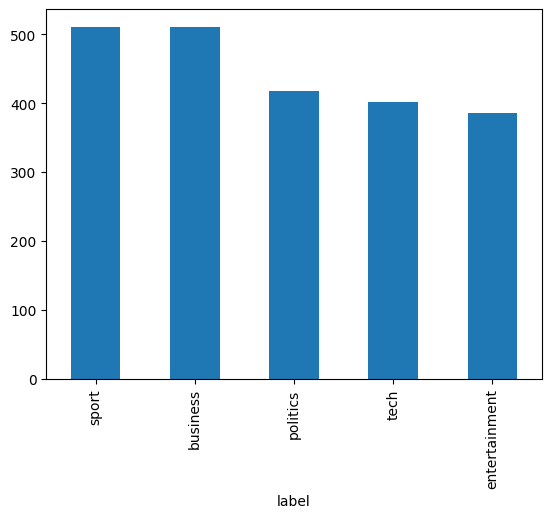

In [ ]:
df.label.value_counts().plot(kind="bar")

## 1.3- Trích đặc trưng


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report #, plot_confusion_matrix


[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
text = df.iloc[:, 0].to_numpy().tolist()
target = df.iloc[:, -1].to_numpy()

In [ ]:
type(text)

list

In [ ]:
type(target)

numpy.ndarray

In [ ]:
target[0]

'entertainment'

In [ ]:
en_stopwords = stopwords.words('english')

bow_vectorizer = CountVectorizer(stop_words=en_stopwords)
tfidf_vectorizer = TfidfVectorizer(stop_words=en_stopwords)


X_bow = bow_vectorizer.fit_transform(text)
X_tfidf = tfidf_vectorizer.fit_transform(text)

In [ ]:
type(en_stopwords)

list

In [ ]:
len(en_stopwords)

179

In [ ]:
en_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
type(X_bow)

scipy.sparse._csr.csr_matrix

In [ ]:
X_bow.shape

(2225, 29280)

In [ ]:
bow_vectorizer.vocabulary_

{'elvis': 9442,
 'set': 23637,
 'top': 26692,
 'uk': 27262,
 'singles': 24140,
 'chart': 5617,
 'rock': 22612,
 'roll': 22649,
 'legend': 15675,
 'sunday': 25590,
 '27': 622,
 'years': 29124,
 'death': 7670,
 'release': 21888,
 'hit': 13030,
 'song': 24552,
 'jailhouse': 14559,
 'selling': 23521,
 'factor': 10318,
 'winner': 28782,
 'steve': 25155,
 'brockstein': 4661,
 'cover': 7108,
 'odds': 18638,
 '000': 1,
 'copies': 6916,
 'tuesday': 27123,
 'record': 21596,
 'make': 16452,
 'spot': 24845,
 '19th': 460,
 'number': 18504,
 'one': 18756,
 'last': 15503,
 'time': 26553,
 'topped': 26697,
 'charts': 5623,
 'remix': 21962,
 'little': 16004,
 'known': 15233,
 'less': 15744,
 'conversation': 6858,
 'june': 14874,
 '2002': 473,
 'reach': 21430,
 '999th': 1464,
 'history': 13029,
 'pop': 20262,
 'first': 10810,
 '1958': 406,
 'analysts': 2400,
 'say': 23137,
 'could': 7044,
 'score': 23290,
 '1000th': 72,
 'well': 28552,
 'night': 18288,
 'released': 21889,
 'following': 11027,
 'week': 2

In [ ]:
len(bow_vectorizer.vocabulary_.keys())

29280

In [ ]:
X_all = X_bow.toarray()
type(X_all)

numpy.ndarray

In [ ]:
X_all[:10, :50]

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
np.array(list(bow_vectorizer.vocabulary_.values())).min()

0

In [ ]:
np.array(list(bow_vectorizer.vocabulary_.values())).max()

29279

In [ ]:
idx2word = dict(zip(list(bow_vectorizer.vocabulary_.values()), list(bow_vectorizer.vocabulary_.keys())))

In [ ]:
idx2word[1]

'000'

## 1.4- Biến đổi nhãn
* Có 3 kiểu biểu diễn nhãn cho bài toán phân loại
  * (1) Văn bản: cho người dùng
  * (2) Chỉ số: thông thường là chỉ số của "nhãn văn bản" trong danh sách đã xếp thứ tự.
    * Cách khác: tự xây dựng mộ ```dict``` ánh xạ từ văn bản sang chỉ số
  * (3) One-hot vector (vector chỉ một con số 1)
  


In [ ]:
class_names

['entertainment', 'sport', 'politics', 'business', 'tech']

In [ ]:
target

array(['entertainment', 'entertainment', 'entertainment', ..., 'tech',
       'tech', 'tech'], dtype=object)

In [ ]:
le = LabelEncoder()
y_all = le.fit_transform(target)

In [ ]:
y_all

array([1, 1, 1, ..., 4, 4, 4])

## 1.5 Chia tách dữ liệu:
* Các tập dữ liệu:
  * Tập huấn luyện (Trainining set): dùng để xây dựng mô hình
    * Xây dựng: huấn luyện, cho mô hình học từ dữ liệu này

  * Tập kiểm thử (Validation set): Đánh giá hiệu quả của mô hình và để **điều chỉnh siêu tham số**
  * Tập kiểm tra (Testing set): Đánh giá hiệu quả của mô hình và **công bố**

* Lấy mẫu cho ba tập: theo nguyên lý **i.i.d** (identical and independent distribution)


In [ ]:
print(f"Dữ liệu toàn bộ: {X_all.shape}")
print(f"Nhãn toàn bộ: {y_all.shape}")

Dữ liệu toàn bộ: (2225, 29280)
Nhãn toàn bộ: (2225,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=2023)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (1557, 29280)
y_train.shape: (1557,)
X_test.shape: (668, 29280)
y_test.shape: (668,)


# 2- Phân tích dữ liệu bằng học máy

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = MultinomialNB().fit(X_train, y_train)
y_pred = model.predict(X_test)


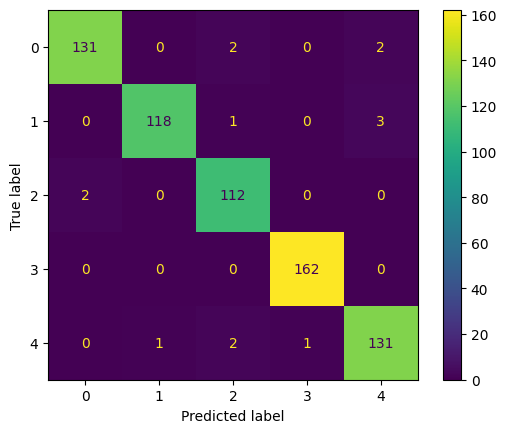

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

entertainment       0.98      0.97      0.98       135
        sport       0.99      0.97      0.98       122
     politics       0.96      0.98      0.97       114
     business       0.99      1.00      1.00       162
         tech       0.96      0.97      0.97       135

     accuracy                           0.98       668
    macro avg       0.98      0.98      0.98       668
 weighted avg       0.98      0.98      0.98       668



# 3-Thử nghiệm với các kỹ thuật khác

               precision    recall  f1-score   support

entertainment       0.96      0.97      0.96       135
        sport       0.99      0.94      0.97       122
     politics       0.97      0.97      0.97       114
     business       1.00      0.99      0.99       162
         tech       0.92      0.96      0.94       135

     accuracy                           0.97       668
    macro avg       0.97      0.97      0.97       668
 weighted avg       0.97      0.97      0.97       668



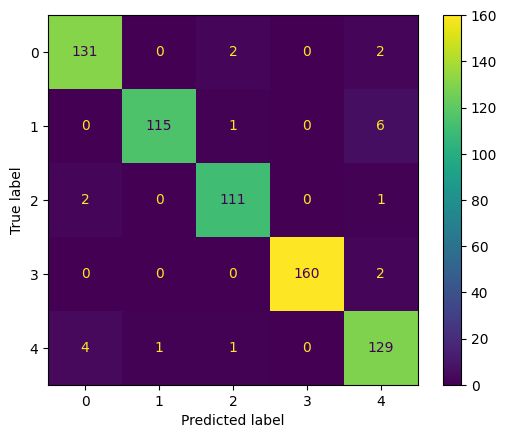

In [ ]:
from sklearn.svm import SVC
model = SVC().fit(X_train, y_train)
y_pred = model.predict(X_test)

#
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

entertainment       0.78      0.81      0.79       135
        sport       0.88      0.83      0.85       122
     politics       0.80      0.87      0.84       114
     business       0.92      0.95      0.94       162
         tech       0.86      0.79      0.82       135

     accuracy                           0.85       668
    macro avg       0.85      0.85      0.85       668
 weighted avg       0.85      0.85      0.85       668



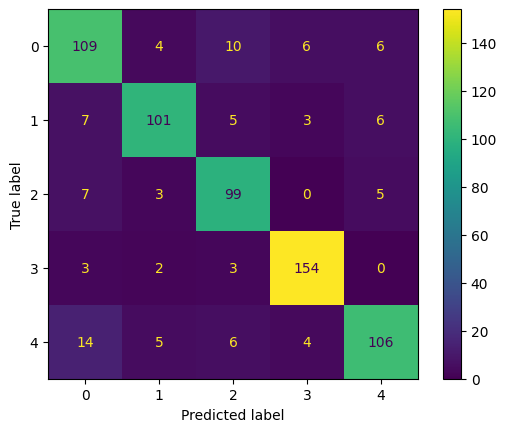

In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier().fit(X_train, y_train)
y_pred = model.predict(X_test)

#
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

entertainment       0.96      0.99      0.97       135
        sport       0.99      0.98      0.99       122
     politics       0.99      0.98      0.99       114
     business       0.98      1.00      0.99       162
         tech       0.98      0.96      0.97       135

     accuracy                           0.98       668
    macro avg       0.98      0.98      0.98       668
 weighted avg       0.98      0.98      0.98       668



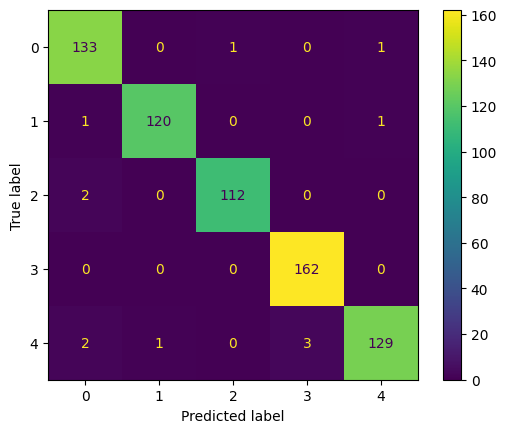

In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(500, 100)).fit(X_train, y_train)
y_pred = model.predict(X_test)

#
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

print(classification_report(y_test, y_pred, target_names=class_names))